# Self-Organizing Map

In [18]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select
from src.utils.distributed_silhouette import DistributedSilhouette

import json

In [19]:
connection = connect_to_spotify_dataset() # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [20]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,False,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.744000,0.151,0.127,104.851,3,1920,0.3460,4.1857,0.5450,0.6264
1,2B9d7LBGJvQEKiLEAexCOP,Toda Alma - Remasterizado,0,180253,False,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.545,0.268,...,0.920000,0.112,0.648,126.614,4,1920,0.5411,7.2483,0.4065,0.8898
2,3fKqEoaJZODF7Xhh7qH4Wv,Capítulo 2.10 - Banquero Anarquista,0,106800,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.702,0.200,...,0.000000,0.360,0.773,81.152,4,1920,0.6371,7.2689,0.4510,0.7052
3,3h8ioTTWfrC25hrHwQQpLc,All Or Nothing at All,0,164320,False,"[Dick Haymes, Harry James, His Orchestra]","[3BiJGZsyX9sJchTqcSA7Su, 5MpELOfAiq7aIBTij30ph...",1922,0.237,0.555,...,0.000262,0.366,0.292,92.213,3,1920,0.3281,2.2666,0.3960,0.6652
4,3rcerSJNOkfgB9CELqcRHL,Capítulo 1.5 - Banquero Anarquista,0,108200,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.773,0.155,...,0.000000,0.130,0.494,52.032,4,1920,0.5099,7.6010,0.4640,0.6926


# Feature Engineering

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

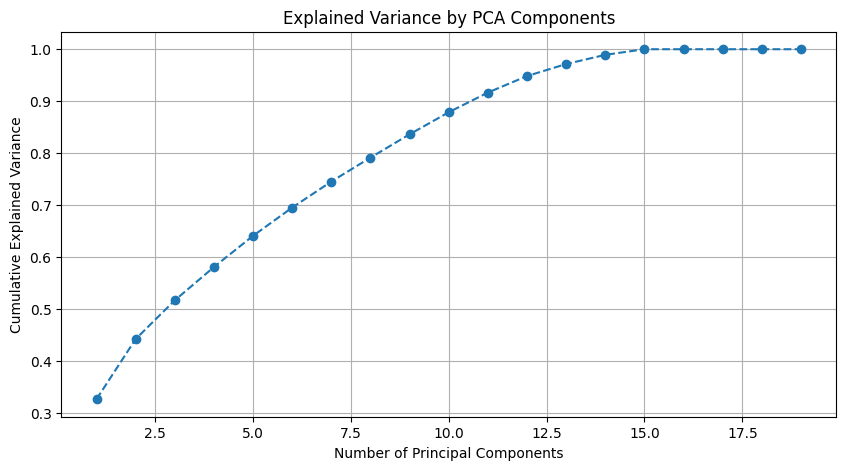

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [15]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [16]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,2.850335,-1.142593,-0.139927,1.100900,-0.323914,1.688455,0.170356,-1.619641,0.754358,-1.237909,-1.378983,-1.966582,-0.065796
1,4.782921,-2.613566,-1.382054,-0.410290,0.134007,2.592092,-0.909475,-0.947700,0.534420,-0.317314,0.180578,-0.421906,-0.531435
2,3.471532,-4.868485,2.170714,1.944426,0.935804,1.095645,-0.180937,1.267889,0.375248,-0.003505,-2.083327,-0.161148,-0.955737
3,2.316427,0.526614,-1.255247,1.979627,0.264365,-1.790033,1.217926,-2.442833,-0.609599,-0.205432,-0.959742,0.523042,-0.839259
4,3.984604,-4.231443,3.109606,0.513646,2.428262,0.627852,0.499387,0.738090,-0.395483,-0.816502,-3.031835,-0.228948,-0.698584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,2.949409,-2.105609,-0.727098,-0.145893,0.817069,-1.026310,0.559714,-1.178877,-0.664751,0.140513,-0.887888,0.888050,-0.785680
525583,2.832162,-4.926818,1.329689,2.106337,-0.360467,1.185493,-0.706966,0.187178,-0.709177,0.634154,-1.774095,-0.997550,-0.955335
525584,3.019127,-4.463060,1.770592,1.931700,-0.401105,1.017625,0.617963,-0.026655,-0.337722,0.280858,-2.190338,-1.275294,-1.046852
525585,3.638911,-2.707100,-1.521952,-1.024173,1.759140,1.117252,0.985322,-2.090713,0.384924,-0.763986,0.576549,-0.069886,-1.383724


### Model Training

In [17]:
from minisom import MiniSom

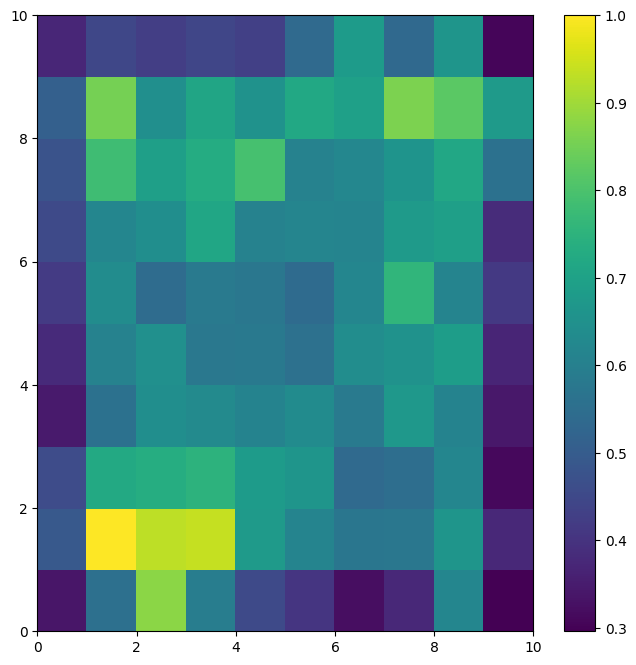

Grid Size: 10x10 - Inertia: 2936547.6785, Quantization Error: 2.2636


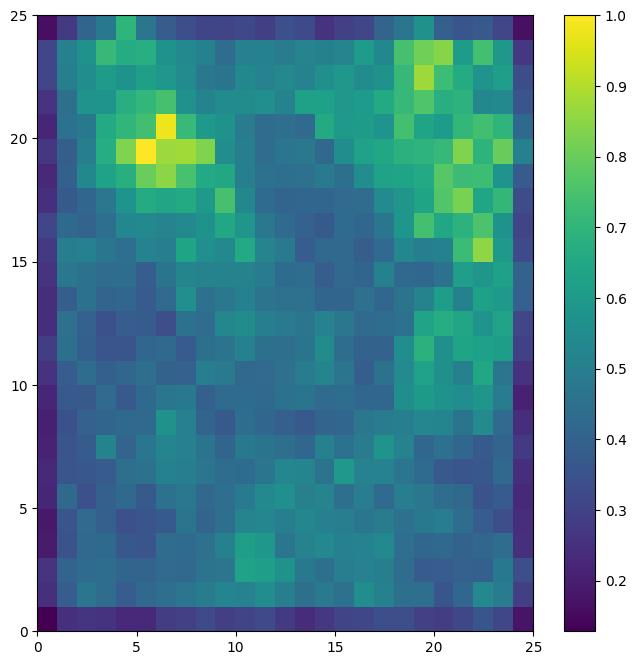

Grid Size: 25x25 - Inertia: 1917071.2749, Quantization Error: 1.8217


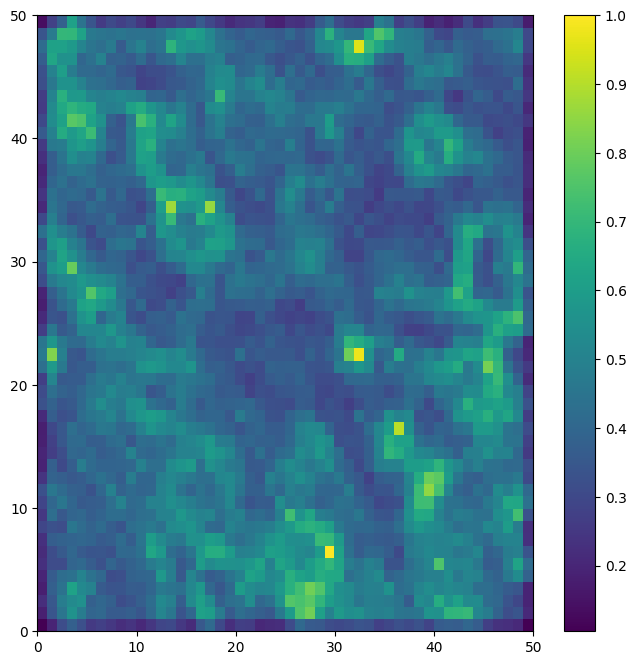

Grid Size: 50x50 - Inertia: 1446151.4981, Quantization Error: 1.5743


In [ ]:
# MiniSom Clustering Model
grid_sizes = [[10,10],[25,25],[50,50],[100,100]]
for x,y in grid_sizes:
    
    grid_x, grid_y = x,y

    # Initialize SOM
    som = MiniSom(grid_x, grid_y, 13, sigma=1.0, learning_rate=0.3)
    som.random_weights_init(X_pca_final)

    # Train SOM
    som.train_random(X_pca_final,100000)

    # Assign each data point to its Best Matching Unit (BMU)
    bmu_indices = np.array([som.winner(x) for x in X_pca_final])

    # Convert BMU indices to cluster labels
    cluster_labels = np.array([x * grid_y + y for x, y in bmu_indices])

    # Compute Sum of squared Euclidean distances to BMUs
    bmu_weights = np.array([som.get_weights()[x, y] for x, y in bmu_indices])
    inertia = np.sum(np.linalg.norm(X_pca_final - bmu_weights, axis=1) ** 2)
    
    # Compute Quantization Error (average Euclidean distance to BMUs)
    quantization_error = np.mean(np.linalg.norm(X_pca_final - bmu_weights, axis=1))
    # create the grid
    plt.figure(figsize=(8, 8))
    #plot the distance map
    plt.pcolor(som.distance_map().T) 
    # show the color bar
    plt.colorbar()
    plt.show()

    print(f"Grid Size: {grid_x}x{grid_y} - Inertia: {inertia:.4f}, Quantization Error: {quantization_error:.4f}")

In [10]:
neighborhood_functions = ['gaussian', 'mexican_hat', 'bubble', 'triangle']
activation_distance = ['euclidean', 'cosine', 'manhattan', 'chebyshev']
lowest_inertia = float('inf')
best_som = None
for i in range(4):
    for j in range(4):
        som = MiniSom(100, 100, 13, sigma=1.0, learning_rate=0.3,neighborhood_function=neighborhood_functions[i],activation_distance=activation_distance[j])
        
        som.random_weights_init(X_pca_final)
        
        som.train_random(X_pca_final,525587) # One iteration per Sample

        bmu_indices = np.array([som.winner(x) for x in X_pca_final])
        bmu_weights = np.array([som.get_weights()[x, y] for x, y in bmu_indices])
        
        inertia = np.sum(np.linalg.norm(X_pca_final - bmu_weights, axis=1) ** 2)
        print(f"n_func: {neighborhood_functions[i]} a_distance: {activation_distance[j]} inertia: {inertia}")

        if inertia < lowest_inertia:
            best_som = som
            inertia = lowest_inertia
som = best_som

n_func: gaussian a_distance: euclidean inertia: 943952.3864876596
n_func: gaussian a_distance: cosine inertia: 1027798.5342921827
n_func: gaussian a_distance: manhattan inertia: 1027353.0071562127
n_func: gaussian a_distance: chebyshev inertia: 3119058.810330504
n_func: mexican_hat a_distance: euclidean inertia: 1889459.763800801
n_func: mexican_hat a_distance: cosine inertia: 3.4444216746631946e+42
n_func: mexican_hat a_distance: manhattan inertia: 2024902.1296890543
n_func: mexican_hat a_distance: chebyshev inertia: 4833874.838061304
n_func: bubble a_distance: euclidean inertia: 892080.0544773863
n_func: bubble a_distance: cosine inertia: 989526.5123725604
n_func: bubble a_distance: manhattan inertia: 967456.3446377078
n_func: bubble a_distance: chebyshev inertia: 3038884.588178261
n_func: triangle a_distance: euclidean inertia: 908256.2521465989
n_func: triangle a_distance: cosine inertia: 997271.1617684328
n_func: triangle a_distance: manhattan inertia: 982366.4483161262
n_func: tr

In [20]:
som = MiniSom(100, 100, 13, sigma=1.0, learning_rate=0.3,neighborhood_function='triangle',activation_distance='euclidean')
som.random_weights_init(X_pca_final)
som.train_random(X_pca_final,525587)

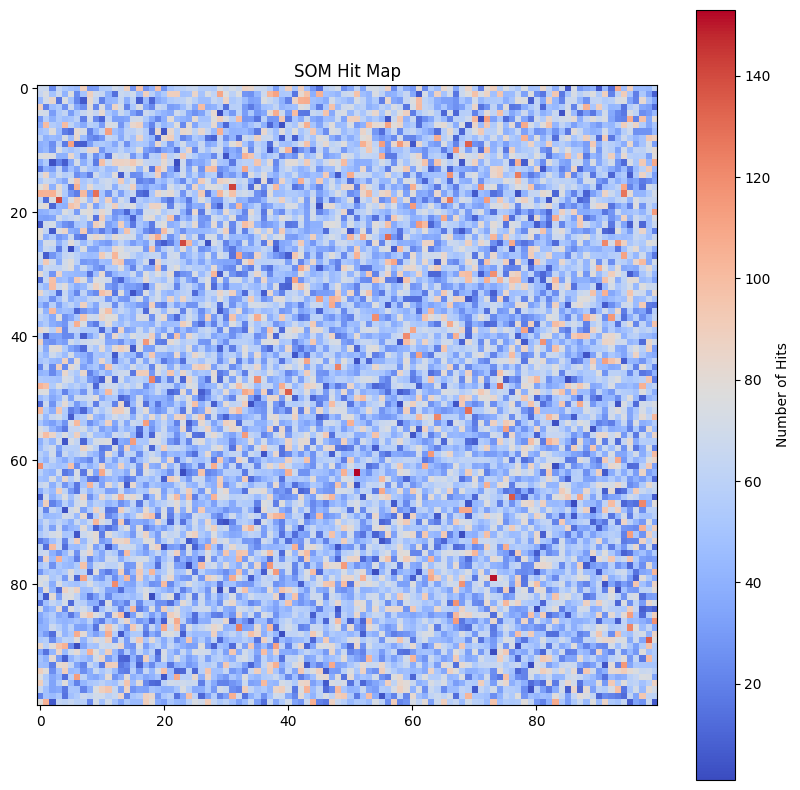

In [21]:
from collections import Counter

bmus = [tuple(som.winner(d)) for d in X_pca_final]
bmu_counts = Counter(bmus)

hit_map = np.zeros((100, 100))
for (x, y), count in bmu_counts.items():
    hit_map[x, y] = count

# Hit Map
plt.figure(figsize=(10, 10))
plt.imshow(hit_map, cmap='coolwarm', origin='upper')
plt.colorbar(label="Number of Hits")
plt.title("SOM Hit Map")
plt.show()

In [25]:
df['bmu'] = bmus
df['bmu'] = df['bmu'].apply(list)
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index,bmu
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,False,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.151,0.127,104.851,3,1920,0.3460,4.1857,0.5450,0.6264,"[63, 40]"
1,2B9d7LBGJvQEKiLEAexCOP,Toda Alma - Remasterizado,0,180253,False,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.545,0.268,...,0.112,0.648,126.614,4,1920,0.5411,7.2483,0.4065,0.8898,"[57, 18]"
2,3fKqEoaJZODF7Xhh7qH4Wv,Capítulo 2.10 - Banquero Anarquista,0,106800,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.702,0.200,...,0.360,0.773,81.152,4,1920,0.6371,7.2689,0.4510,0.7052,"[89, 98]"
3,3h8ioTTWfrC25hrHwQQpLc,All Or Nothing at All,0,164320,False,"[Dick Haymes, Harry James, His Orchestra]","[3BiJGZsyX9sJchTqcSA7Su, 5MpELOfAiq7aIBTij30ph...",1922,0.237,0.555,...,0.366,0.292,92.213,3,1920,0.3281,2.2666,0.3960,0.6652,"[50, 3]"
4,3rcerSJNOkfgB9CELqcRHL,Capítulo 1.5 - Banquero Anarquista,0,108200,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.773,0.155,...,0.130,0.494,52.032,4,1920,0.5099,7.6010,0.4640,0.6926,"[27, 51]"


In [26]:
df.to_json("bmu_data.json", orient="records", indent=4)

### Silhouette Score

In [33]:
with open("bmu_data.json", "r") as f:
    cluster_labels = json.load(f)
labels_array = bmu_array = np.array([entry['bmu'] for entry in cluster_labels]) 

bmu_tuples = [tuple(bmu) for bmu in labels_array]  # Convert to list of tuples
unique_bmus = list(set(bmu_tuples))  # Get unique BMU positions
bmu_to_label = {bmu: i for i, bmu in enumerate(unique_bmus)}  # Assign unique labels
labels = np.array([bmu_to_label[bmu] for bmu in bmu_tuples])  # Map BMUs to labels

In [34]:
silhouette_calculator = DistributedSilhouette(M=10)  # Adjust M as needed
num_samples = 525587
M = silhouette_calculator.M  

partitions = np.array_split(X, M)
label_partitions = np.array_split(labels, M)

silhouette_score = silhouette_calculator.compute_fast_silhouette(partitions, label_partitions)
print(f"Silhouette Score: {silhouette_score}")

Setting up the droplet clones...


DataReadError: creating this/these droplet(s) will exceed your droplet limit